# Import data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
def analize(x):
    x['NameLength'] = x['Name'].apply(len)
    x['HasCabin'] = x['Cabin'].apply(lambda i: 1 if type(i)==str else 0)
    x['FamilySize'] = 1 + x['Parch'] + x['SibSp']
    
    x['IsAlone'] = 0
    x.loc[x['FamilySize']==1, 'IsAlone'] = 1

    x['Embarked'] = x['Embarked'].fillna('S')
    x['Embarked'] = x['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

    x['Fare'] = x['Fare'].fillna(x['Fare'].median())
    CategoricalFare = pd.cut(x['Fare'], 5)
    # output: [(-0.512, 102.466] < (102.466, 204.932] < (204.932, 307.398] < (307.398, 409.863] < (409.863, 512.329]]
    x.loc[x['Fare']<=102, 'Fare'] = 0
    x.loc[(x['Fare']>102) & (x['Fare']<=204), 'Fare'] = 1
    x.loc[(x['Fare']>204) & (x['Fare']<=307), 'Fare'] = 2
    x.loc[(x['Fare']>307) & (x['Fare']<=409), 'Fare'] = 3
    x.loc[(x['Fare']>409) & (x['Fare']<=512), 'Fare'] = 4
    x['Fare'] = x['Fare'].astype(int)


    # --- Age
    mean = x['Age'].mean()
    std = x['Age'].std()
    randomAge = np.random.randint(mean-std, mean+std, size=x['Age'].isnull().sum())
    x['Age'][np.isnan(x['Age'])] = randomAge
    CategoricalAge = pd.cut(x['Age'], 5)
    # output: [(0.34, 16.336] < (16.336, 32.252] < (32.252, 48.168] < (48.168, 64.084] < (64.084, 80.0]]
    x.loc[x['Age']<=16 , 'Age'] = 0
    x.loc[(x['Age']>16) & (x['Age']<=32), 'Age'] = 1
    x.loc[(x['Age']>32) & (x['Age']<=48), 'Age'] = 2
    x.loc[(x['Age']>48) & (x['Age']<=64), 'Age'] = 3
    x.loc[(x['Age']>64) & (x['Age']<=80), 'Age'] = 4
    x['Age'] = x['Age'].astype(int)

    # --- Title
    x['Title'] = [i.split(', ')[1].split('.')[0] for i in x['Name']]
    x['Title'] = x["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    x['Title'] = x['Title'].replace(['Mlle', 'Ms'], 'Miss')
    x['Title'] = x['Title'].replace('Mme', 'Mrs')
    x['Title'] = x['Title'].map({"Mr": 0, "Miss": 1, "Mrs": 2, "Master": 3, "Rare": 4})

    x['Sex'] = x['Sex'].map({'male':0, 'female':1}).astype(int)
    
    x = x.drop(columns=['PassengerId','Name','SibSp','Parch','Ticket','Cabin'])
    return x

## Training

In [4]:
train = analize(df_train)
train.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Survived,Pclass,Sex,Age,Fare,Embarked,NameLength,HasCabin,FamilySize,IsAlone,Title
0,0,3,0,1,0,0,23,0,2,0,0
1,1,1,1,2,0,1,51,1,2,0,2
2,1,3,1,1,0,0,22,0,1,1,1
3,1,1,1,2,0,0,44,1,2,0,2
4,0,3,0,2,0,0,24,0,1,1,0


In [5]:
y = train['Survived'].values
x = train.iloc[:, 1:].values

X_train, X_test, y_train, y_test = train_test_split(x,y, random_state=0)

In [6]:
classifier = RandomForestClassifier(n_estimators=100, max_depth=20, max_features='sqrt', n_jobs=-1)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

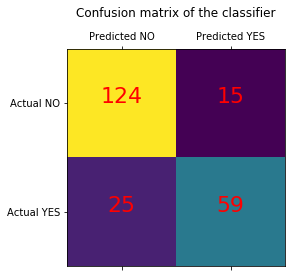

In [7]:
cm = confusion_matrix(y_test, y_pred)
import itertools
labels = ['Predicted NO', 'Predicted YES','Actual NO','Actual YES']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier\n')
ax.set_xticklabels([''] + labels[0:2])
ax.set_yticklabels([''] + labels[2:4])
fmt = '.0f'
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
        horizontalalignment="center",
        color="red", fontsize = 22)
plt.show()

In [8]:
(cm[0][0]+cm[1][1])/len(X_test)

0.820627802690583

## Prediction

In [9]:
test = analize(df_test)
test.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Pclass,Sex,Age,Fare,Embarked,NameLength,HasCabin,FamilySize,IsAlone,Title
0,3,0,2,0,2,16,0,1,1,0
1,3,1,2,0,0,32,0,2,0,2
2,2,0,3,0,2,25,0,1,1,0
3,3,0,1,0,0,16,0,1,1,0
4,3,1,1,0,0,44,0,3,0,2


In [10]:
output_train = train['Survived'].values
intput_train = train.drop(columns=['Survived']).values
input_test = test.values

In [11]:
output_pred = classifier.predict(input_test)

In [12]:
result = pd.DataFrame({
    'PassengerId': df_test['PassengerId'],
    'Survived': output_pred.astype(int)
})

In [13]:
result.to_csv('result.csv', index=False)